In [4]:
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [ ]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)
subjectlist1.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 27)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,...,NaT,NaN,1,False,True,NaN,0.0,NaN,121,nonfailure
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,...,NaT,NaN,2,False,True,NaN,0.0,NaN,2221,nonfailure


In [137]:
subjectlist1

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,...,NaT,NaN,1,False,True,NaN,0.0,NaN,121,nonfailure
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,...,NaT,NaN,2,False,True,NaN,0.0,NaN,2221,nonfailure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,...,2126-05-05 18:20:00,4430.0,2,False,False,NaN,24345.0,NaN,212,nonfailure
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,...,NaT,NaN,3,False,True,NaN,15646.0,NaN,221,nonfailure
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,...,NaT,NaN,1,False,True,NaN,7525.0,NaN,11,nonfailure
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,...,NaT,NaN,1,True,True,NaN,20290.0,NaN,11,nonfailure


<Axes: >

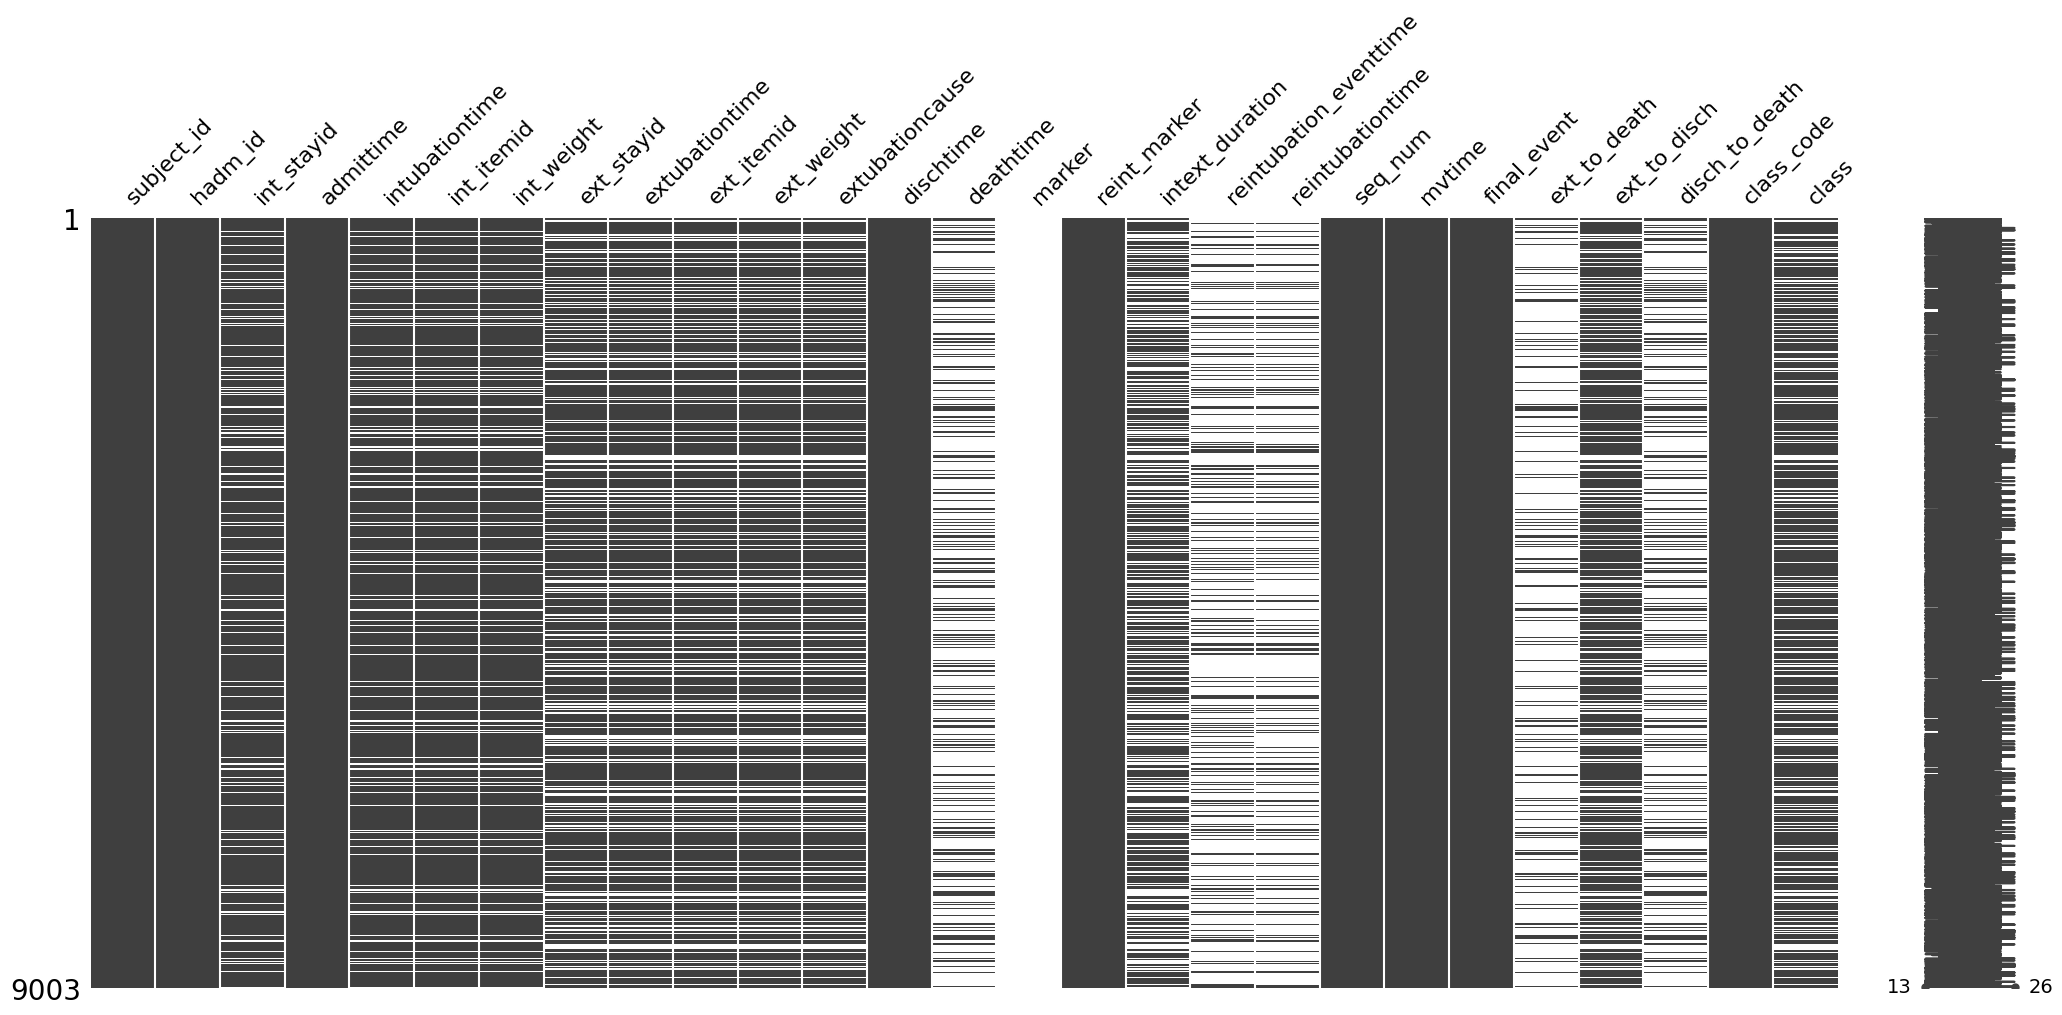

In [97]:
msno.matrix(subjectlist)

In [7]:
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {'ventilation': "select * from mimiciv_derived.ventilation;"}

db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

ventilation = dataframes['ventilation']

INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
ventilation: select * from mimiciv_derived.ventilation;



INFO:root:Retrieved ventilation: (111237, 4)
INFO:root:DATABASE CONNCETION CLOSED.


In [9]:
ventilation

,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
1,30000153,2174-09-29 20:00:00,2174-10-01 00:57:00,SupplementalOxygen
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
3,30000484,2136-01-14 18:46:00,2136-01-17 04:00:00,SupplementalOxygen
4,30000646,2194-04-29 01:40:00,2194-05-03 16:00:00,SupplementalOxygen
...,...,...,...,...
111232,39999230,2147-09-07 13:00:00,2147-09-09 17:00:00,SupplementalOxygen
111233,39999301,2111-08-18 16:11:00,2111-08-19 08:00:00,SupplementalOxygen
111234,39999384,2158-05-24 22:00:00,2158-05-25 04:00:00,SupplementalOxygen
111235,39999552,2186-07-17 16:00:00,2186-07-17 22:00:00,InvasiveVent


In [11]:
ventilation.to_csv('../outputs/ventilation.csv')

In [8]:
subjectlist.columns

Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class'],
      dtype='object')

In [4]:
ventilation.columns

Index(['stay_id', 'starttime', 'endtime', 'ventilation_status'], dtype='object')

In [5]:
ventilation.head()

,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
1,30000153,2174-09-29 20:00:00,2174-10-01 00:57:00,SupplementalOxygen
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
3,30000484,2136-01-14 18:46:00,2136-01-17 04:00:00,SupplementalOxygen
4,30000646,2194-04-29 01:40:00,2194-05-03 16:00:00,SupplementalOxygen


In [30]:
test_subjectlist = subjectlist[subjectlist.reint_marker == True][['hadm_id', 'int_stayid', 'intubationtime', 'ext_stayid', 'extubationtime', 'intext_duration', 'seq_num', 'final_event', 'mvtime']]
test_subjectlist[test_subjectlist.hadm_id == 21588174]

,hadm_id,int_stayid,intubationtime,ext_stayid,extubationtime,intext_duration,seq_num,final_event,mvtime
8990,21588174,30916791.0,2166-06-14 08:58:00,30916791.0,2166-06-14 10:47:00,109.0,1,False,True
8991,21588174,31169972.0,2166-06-19 09:20:00,NaN,2166-06-19 21:15:00,715.0,2,True,True


In [20]:
ventilation[ventilation.stay_id == 30916791]

,stay_id,starttime,endtime,ventilation_status
10144,30916791,2166-06-13 16:36:00,2166-06-14 08:00:00,SupplementalOxygen
10145,30916791,2166-06-14 08:00:00,2166-06-14 12:00:00,InvasiveVent
10146,30916791,2166-06-14 12:00:00,2166-06-14 22:00:00,SupplementalOxygen
10147,30916791,2166-06-14 23:07:00,2166-06-16 12:00:00,SupplementalOxygen


In [17]:
test_subjectlist[test_subjectlist.mvtime == True]

,int_stayid,intubationtime,ext_stayid,extubationtime,intext_duration,mvtime
14,35889503.0,2150-03-27 07:44:00,35889503.0,2150-03-27 16:33:00,529.0,True
48,35381116.0,2115-10-11 14:05:00,35381116.0,2115-10-11 15:40:00,95.0,True
52,36886741.0,2192-12-15 22:30:00,36886741.0,2192-12-16 11:45:00,795.0,True
56,38669202.0,2169-02-10 16:22:00,38669202.0,2169-02-10 21:16:00,294.0,True
80,36809666.0,2184-08-20 08:42:00,36809666.0,2184-08-20 11:30:00,168.0,True
...,...,...,...,...,...,...
8960,32028235.0,2145-06-03 04:00:00,NaN,2145-06-03 05:16:00,76.0,True
8975,33646490.0,2122-01-13 01:00:00,33646490.0,2122-01-13 03:11:00,131.0,True
8990,30916791.0,2166-06-14 08:58:00,30916791.0,2166-06-14 10:47:00,109.0,True
8991,31169972.0,2166-06-19 09:20:00,NaN,2166-06-19 21:15:00,715.0,True


In [36]:
# raw data를 보자
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/이수정/mimic4_ext_codes/data/intubation_extubation.csv'
raw_vent = pd.read_csv(data_dir)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime']
raw_vent = utils.to_datetime(raw_vent, time_cols)
print(raw_vent.shape)
raw_vent.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(10992, 14)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-11 04:30:00,224385,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-08-17 21:21:00,224385,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-11 05:03:00,224385,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-01-27 19:00:00,224385,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-01-30 13:00:00,224385,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT


In [37]:
raw_vent[raw_vent.int_stayid == 30916791]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
10968,19983257,21588174,30916791,2166-06-13 14:21:00,2166-06-14 08:58:00,224385,118.6,30916791.0,2166-06-14 10:47:00,227194.0,118.6,Planned Extubation,2166-06-19 21:15:00,2166-06-19 21:15:00



---

In [40]:
event_type = ['Tracheostomy', 'InvasiveVent', 'HFNC']

vent_filtered = ventilation[ventilation.ventilation_status.isin(event_type)]
vent_filtered

,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
5,30001148,2156-08-30 14:50:00,2156-08-30 18:00:00,InvasiveVent
12,30001656,2177-03-15 17:32:00,2177-03-16 12:00:00,InvasiveVent
14,30001947,2162-12-26 19:00:00,2162-12-27 09:19:00,InvasiveVent
...,...,...,...,...
111224,39997753,2110-09-11 23:00:00,2110-09-12 14:00:00,InvasiveVent
111226,39998012,2133-02-03 15:00:00,2133-02-08 16:00:00,InvasiveVent
111227,39998622,2135-02-11 18:15:00,2135-02-14 08:00:00,InvasiveVent
111228,39998622,2135-02-17 09:00:00,2135-02-18 08:00:00,InvasiveVent


In [46]:
# 환자 데이터에 포함된 stayid만 추출

unique_intstay = subjectlist.int_stayid.unique()
unique_extstay = subjectlist.ext_stayid.unique()

# Convert each list to a set
set_intstay = set(unique_intstay)
set_extstay = set(unique_extstay)

# Use set union to combine and deduplicate
combined_unique_stay = set_intstay.union(set_extstay)

# Convert back to a list if you need a list structure
combined_unique_stay_list = list(combined_unique_stay)

# combined_unique_stay_list now contains unique values from both original lists
len(combined_unique_stay_list)

vent_filtered = vent_filtered[vent_filtered.stay_id.isin(combined_unique_stay_list)]
vent_filtered.shape

(12401, 4)

In [54]:
vent_filtered.head()

,stay_id,starttime,endtime,ventilation_status
5,30001148,2156-08-30 14:50:00,2156-08-30 18:00:00,InvasiveVent
12,30001656,2177-03-15 17:32:00,2177-03-16 12:00:00,InvasiveVent
14,30001947,2162-12-26 19:00:00,2162-12-27 09:19:00,InvasiveVent
32,30004144,2126-04-05 16:00:00,2126-04-06 17:00:00,InvasiveVent
33,30004144,2126-04-06 18:00:00,2126-04-07 08:00:00,InvasiveVent


In [48]:
subjectlist[subjectlist.int_stayid == 39991569]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
3102,13439409,22868166,39991569.0,2179-04-10 14:39:00,2179-04-10 17:25:00,224385.0,94.2,39991569.0,2179-04-11 16:18:00,227194.0,...,NaT,NaN,1,True,True,NaN,11502.0,NaN,11,nonfailure


In [49]:
vent_filtered[vent_filtered.stay_id == 39991569]

,stay_id,starttime,endtime,ventilation_status
111180,39991569,2179-04-10 17:22:00,2179-04-11 20:00:00,InvasiveVent


In [52]:
subjectlist[subjectlist.ext_stayid == 39995735]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
1384,11539827,21192405,NaN,2124-08-05 14:24:00,NaT,NaN,NaN,39995735.0,2124-08-21 06:17:00,227194.0,...,2124-08-23 10:30:00,3133.0,1,False,False,NaN,22131.0,NaN,212,nonfailure


In [53]:
vent_filtered[vent_filtered.stay_id == 39995735]

,stay_id,starttime,endtime,ventilation_status
111204,39995735,2124-08-15 18:00:00,2124-08-21 09:58:00,InvasiveVent


In [55]:
subjectlist[subjectlist.int_stayid == 30004144]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
335,10369174,24697158,30004144.0,2126-04-04 08:00:00,2126-04-05 16:00:00,224385.0,80.0,30004144.0,2126-04-06 13:00:00,227194.0,...,NaT,NaN,1,True,True,NaN,7142.0,NaN,11,nonfailure


In [56]:
vent_filtered[vent_filtered.stay_id == 30004144]

,stay_id,starttime,endtime,ventilation_status
32,30004144,2126-04-05 16:00:00,2126-04-06 17:00:00,InvasiveVent
33,30004144,2126-04-06 18:00:00,2126-04-07 08:00:00,InvasiveVent


In [59]:
subjectlist[(subjectlist.intubationtime.isna()) | (subjectlist.extubationtime.isna())]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
12,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,...,NaT,NaN,1,False,False,NaN,63095.0,NaN,9999,NaN
13,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,227194.0,...,2150-03-27 07:44:00,11319.0,2,False,False,NaN,53445.0,NaN,212,nonfailure
18,10024982,25154057,NaN,2203-09-19 12:29:00,NaT,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,...,2203-10-02 11:00:00,5400.0,1,False,False,18850.0,18850.0,0.0,212,nonfailure
21,10027602,28166872,NaN,2201-10-30 12:05:00,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,227194.0,...,2201-11-07 15:00:00,67.0,1,False,False,NaN,18772.0,NaN,211,failure
47,10079700,24239751,38841663.0,2115-09-14 22:01:00,2115-09-27 17:23:00,224385.0,64.0,NaN,NaT,NaN,...,2115-10-11 14:05:00,NaN,1,False,False,NaN,NaN,NaN,9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8977,19969918,29544887,31213286.0,2186-01-15 23:00:00,2186-01-16 20:29:00,224385.0,68.0,NaN,NaT,NaN,...,2186-01-16 21:10:00,NaN,1,False,False,NaN,NaN,NaN,998,failure
8986,19975796,25848942,NaN,2148-12-02 22:08:00,NaT,NaN,NaN,31651964.0,2148-12-03 10:33:00,227194.0,...,2148-12-04 20:15:00,2022.0,1,False,False,NaN,16167.0,NaN,211,failure
8997,19989918,20256395,NaN,2175-09-18 17:45:00,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,227194.0,...,NaT,NaN,2,False,True,NaN,2985.0,NaN,221,nonfailure
9000,19995595,21784060,NaN,2126-10-17 21:43:00,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,227194.0,...,2126-10-31 00:45:00,619.0,1,False,False,NaN,18909.0,NaN,211,failure


In [60]:
subjectlist[subjectlist.ext_stayid == 35026312.0]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
12,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,...,NaT,NaN,1,False,False,NaN,63095.0,NaN,9999,NaN


In [61]:
vent_filtered[vent_filtered.stay_id == 35026312]

,stay_id,starttime,endtime,ventilation_status
56233,35026312,2150-03-11 16:00:00,2150-03-12 19:00:00,InvasiveVent


----

### 24. 02. 08 imputation test

In [49]:
# 결측치 안건드리는 데이터 불러오기
# 데이터 임포트
reintubation_df = pd.read_csv('../outputs/reintubation_df.csv', index_col=0)

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df = utils.to_datetime(reintubation_df, time_cols)



print(reintubation_df.shape)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9008, 20)


In [50]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

subjects_df = categorize_patients(reintubation_df)

Categorizing extubation failure vs non-failure...:   0%|          | 0/6699 [00:00<?, ?it/s]

Categorizing extubation failure vs non-failure...: 100%|██████████| 6699/6699 [00:15<00:00, 443.91it/s]


--- RUNTIME: 16.81 seconds ---


In [51]:
subjects_df.to_csv('../outputs/subjects_df_nullkeep.csv')

In [54]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjects_df_nullkeep.csv'
subjectlist = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist = utils.to_datetime(subjectlist, time_cols)
subjectlist = subjectlist[subjectlist.intubationtime != subjectlist.extubationtime]
print(subjectlist.shape)
subjectlist.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 27)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,...,NaT,NaN,2,False,True,NaN,NaN,NaN,9999,NaN


In [70]:
ventilation = pd.read_csv('../outputs/ventilation.csv', index_col=0)

# datetime 변환
time_cols = ['starttime', 'endtime']
ventilation = utils.to_datetime(ventilation, time_cols)

print(ventilation.shape)
ventilation.head()

Converted starttime to datetime.
Converted endtime to datetime.
(111237, 4)


,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
1,30000153,2174-09-29 20:00:00,2174-10-01 00:57:00,SupplementalOxygen
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
3,30000484,2136-01-14 18:46:00,2136-01-17 04:00:00,SupplementalOxygen
4,30000646,2194-04-29 01:40:00,2194-05-03 16:00:00,SupplementalOxygen


In [32]:
subjectlist.columns

Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class'],
      dtype='object')

In [59]:
# null 케이스 확인, 단일행 데이터 먼저 처리 n=1428

subjectlist_singlerow = subjectlist[((subjectlist.intubationtime.isna()) | (subjectlist.extubationtime.isna())) & (subjectlist.reint_marker == False) ]
subjectlist_singlerow

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
6,10007818,22987108,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,1250.0,9999,NaN
7,10010058,26359957,33060379.0,2147-11-18 02:34:00,2147-11-18 02:35:00,224385.0,60.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,0.0,9999,NaN
9,10017531,22580355,35526828.0,2159-09-22 19:30:00,2159-09-23 16:01:00,224385.0,119.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
11,10019957,28761725,37708849.0,2135-11-11 10:45:00,2135-11-11 14:35:00,224385.0,76.6,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8980,19970265,24514478,38356273.0,2115-03-28 17:37:00,2115-03-28 18:00:00,224385.0,67.9,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
8984,19971771,26230047,38668070.0,2117-04-26 00:21:00,2117-04-26 00:22:00,224385.0,90.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
8989,19979469,29434840,37363141.0,2202-02-22 18:26:00,2202-02-22 21:40:00,224385.0,86.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
8998,19990427,29695607,34058245.0,2182-01-04 00:00:00,2182-01-14 04:21:00,224385.0,100.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,1395.0,9999,NaN


In [98]:
subjectlist_singlerow[subjectlist_singlerow.intubationtime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class


In [87]:
testrow = subjectlist[subjectlist.int_stayid == 35526828.0]
testrow

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
9,10017531,22580355,35526828.0,2159-09-22 19:30:00,2159-09-23 16:01:00,224385.0,119.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN


In [71]:
ventilation[(ventilation.stay_id == 35526828.0) & (ventilation.ventilation_status == 'InvasiveVent')]

,stay_id,starttime,endtime,ventilation_status
61476,35526828,2159-09-23 17:00:00,2159-10-17 10:43:00,InvasiveVent
61478,35526828,2159-10-17 14:10:00,2159-10-18 12:00:00,InvasiveVent
61479,35526828,2159-10-18 16:00:00,2159-10-21 04:00:00,InvasiveVent
61480,35526828,2159-10-21 19:05:00,2159-10-22 08:00:00,InvasiveVent


기본 조건
1. invativevent (ventilation_status) 만 가지고 작업.
2. starttime이 admittime보다 뒤에 와야 함.
3. endtime이 dischtime보다 앞에 와야 함. 

extubationtime 결측 예시
1. (단일행일 경우) intubationtime 보다 뒤에 와야 함. -> 충족 시 대체
2. (복수행일 경우) starttime이 이전 extubationtime 보다 뒤에 와야 함. 
2. vent 이벤트가 2개 이상일때(이건 가능함, 그러나 제대로된 페어를 찾아줘야 함)


In [72]:
ventilation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111237 entries, 0 to 111236
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   stay_id             111237 non-null  int64         
 1   starttime           111237 non-null  datetime64[ns]
 2   endtime             111237 non-null  datetime64[ns]
 3   ventilation_status  111084 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 4.2+ MB


In [133]:
subjectlist.columns

Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class', 'stay_id'],
      dtype='object')

In [116]:
import pandas as pd

def find_approx_single_vent(ventilation_df, row):
    """
    주어진 row에서 누락된 intubationtime 또는 extubationtime을 찾기 위해 ventilation 테이블을 검색합니다.
    
    Parameters:
    - ventilation_df: 환기 이벤트 데이터를 포함한 DataFrame입니다.
    - row: 단일 환자의 환기 이벤트 정보를 포함한 Series입니다.
    
    Returns:
    - 누락된 intubationtime 또는 extubationtime에 대한 가장 근접한 타임스탬프 값을 반환합니다.
      여러 후보가 있을 경우, 해당 후보들의 타임스탬프 값을 리스트로 반환합니다.
      후보가 없을 경우 None을 반환합니다.
    """

    
    # 누락된 시간에 따라 stayid 할당
    if pd.isnull(row['extubationtime']) and not pd.isnull(row['intubationtime']):
        stayid = row['int_stayid']
        target_time = 'endtime'
        known_time = row['intubationtime']
        compare_time = row['dischtime']
    elif pd.isnull(row['intubationtime']) and not pd.isnull(row['extubationtime']):
        stayid = row['ext_stayid']
        target_time = 'starttime'
        known_time = row['admittime']
        compare_time = row['extubationtime']
    else:
        print("Ambiguous case, both or neither intubation and extubation times are missing.")
        return None
    
    # ventilation_df에서 stay_id에 해당하는 데이터 필터링
    candidates = ventilation_df[ventilation_df['stay_id'] == stayid]
    
    # 누락된 시간에 따른 조건 적용
    candidates = candidates[(candidates[target_time] > known_time) & (candidates[target_time] < compare_time)]
    
    # 여러 후보가 있는 경우, 가장 근접한 시간 찾기
    if len(candidates) > 1:
        candidates['time_diff'] = (candidates[target_time] - known_time).abs()
        min_diff = candidates['time_diff'].min()
        closest_candidates = candidates[candidates['time_diff'] == min_diff]
        
        # 하나의 후보만 있는 경우
        if len(closest_candidates) == 1:
            return pd.Timestamp(closest_candidates[target_time].values[0])  # 가장 근접한 타임스탬프 반환
        else:
            print("Multiple candidate rows found.")
            return [pd.Timestamp(time) for time in closest_candidates[target_time].values] # 가장 근접한 타임스탬프 리스트 반환
    
    # 단 하나의 후보만 있는 경우
    elif len(candidates) == 1:
        return pd.Timestamp(candidates[target_time].values[0])  # 해당 타임스탬프 반환
    
    else:
        print("No candidate rows found.")
        return None


In [101]:
subjectlist[(subjectlist.reint_marker == True) & (subjectlist.intubationtime.isna())]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
12,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,...,NaT,NaN,1,False,False,NaN,63095.0,NaN,9999,NaN
13,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,227194.0,...,2150-03-27 07:44:00,11319.0,2,False,False,NaN,53445.0,NaN,212,nonfailure
18,10024982,25154057,NaN,2203-09-19 12:29:00,NaT,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,...,2203-10-02 11:00:00,5400.0,1,False,False,18850.0,18850.0,0.0,212,nonfailure
21,10027602,28166872,NaN,2201-10-30 12:05:00,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,227194.0,...,2201-11-07 15:00:00,67.0,1,False,False,NaN,18772.0,NaN,211,failure
51,10085667,27382550,NaN,2192-12-11 19:38:00,NaT,NaN,NaN,36886741.0,2192-12-14 14:36:00,227194.0,...,2192-12-15 22:30:00,1914.0,1,False,False,NaN,7374.0,NaN,211,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974,19965802,21104872,NaN,2121-12-27 20:28:00,NaT,NaN,NaN,34618456.0,2122-01-04 15:50:00,227194.0,...,2122-01-13 01:00:00,12070.0,1,False,False,NaN,23090.0,NaN,212,nonfailure
8986,19975796,25848942,NaN,2148-12-02 22:08:00,NaT,NaN,NaN,31651964.0,2148-12-03 10:33:00,227194.0,...,2148-12-04 20:15:00,2022.0,1,False,False,NaN,16167.0,NaN,211,failure
8997,19989918,20256395,NaN,2175-09-18 17:45:00,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,227194.0,...,NaT,NaN,2,False,True,NaN,2985.0,NaN,221,nonfailure
9000,19995595,21784060,NaN,2126-10-17 21:43:00,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,227194.0,...,2126-10-31 00:45:00,619.0,1,False,False,NaN,18909.0,NaN,211,failure


In [135]:
testsub_int = subjectlist[subjectlist.hadm_id == 23831430]
testsub_int

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stay_id
12,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,...,NaN,1,False,False,NaN,63095.0,NaN,9999,NaN,35026312.0
13,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,227194.0,...,11319.0,2,False,False,NaN,53445.0,NaN,212,nonfailure,35044342.0
14,10020740,23831430,35889503.0,2150-03-11 15:34:00,2150-03-27 07:44:00,224385.0,103.0,35889503.0,2150-03-27 16:33:00,227194.0,...,3827.0,3,True,False,NaN,41597.0,NaN,212,nonfailure,35889503.0
15,10020740,23831430,31077365.0,2150-03-11 15:34:00,2150-03-30 08:20:00,224385.0,103.0,31077365.0,2150-04-02 01:09:00,227194.0,...,NaN,4,False,True,NaN,33881.0,NaN,221,nonfailure,31077365.0


In [115]:
testsub_int.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 12 to 15
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              4 non-null      int64         
 1   hadm_id                 4 non-null      int64         
 2   int_stayid              2 non-null      float64       
 3   admittime               4 non-null      datetime64[ns]
 4   intubationtime          2 non-null      datetime64[ns]
 5   int_itemid              2 non-null      float64       
 6   int_weight              2 non-null      float64       
 7   ext_stayid              4 non-null      float64       
 8   extubationtime          4 non-null      datetime64[ns]
 9   ext_itemid              4 non-null      float64       
 10  ext_weight              4 non-null      float64       
 11  extubationcause         4 non-null      object        
 12  dischtime               4 non-null      datetime64[ns]
 1

In [121]:
idxs = []
for idx, rows in subjectlist.iterrows():
    if pd.notnull(rows['int_stayid']) & pd.notnull(rows['ext_stayid']):
        if rows['int_stayid'] != rows['ext_stayid']:
            idxs.append(idx)

print(len(idxs))


98


In [132]:
print('stayid mismatch')
subjectlist.iloc[idxs]['class'].value_counts()

stayid mismatch


class
nonfailure    59
failure       12
death         10
Name: count, dtype: int64

In [118]:
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']

best_candidate = find_approx_single_vent(ventilation_df, testsub_int.iloc[0])
best_candidate

Timestamp('2150-03-11 16:00:00')

In [114]:
type(best_candidate)

numpy.datetime64

In [110]:
ventilation_df[ventilation_df.starttime == '2150-03-11T16:00:00.000000000']

,stay_id,starttime,endtime,ventilation_status
56233,35026312,2150-03-11 16:00:00,2150-03-12 19:00:00,InvasiveVent


In [96]:
best_row = find_approx_vent_event(vent_filtered, testrow.iloc[0])
best_row

61476

In [83]:
inttime = testrow['intubationtime'].unique()[0]
inttime

Timestamp('2159-09-23 16:01:00')

In [113]:
subjectlist['stay_id'] = subjectlist.apply(
    lambda row: row['int_stayid'] if pd.notnull(row['int_stayid']) else row['ext_stayid'], axis=1
)
subjectlist

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stay_id
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure,37510196.0
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure,38383343.0
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,...,NaN,1,False,True,NaN,NaN,NaN,9999,NaN,31202136.0
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,30.0,1,False,False,NaN,10035.0,NaN,211,failure,32773003.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,...,NaN,2,False,True,NaN,NaN,NaN,9999,NaN,32773003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,...,4430.0,2,False,False,NaN,24345.0,NaN,212,nonfailure,35616526.0
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,...,NaN,3,False,True,NaN,15646.0,NaN,221,nonfailure,35616526.0
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,...,NaN,1,False,True,NaN,7525.0,NaN,11,nonfailure,30143796.0
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,...,NaN,1,True,True,NaN,20290.0,NaN,11,nonfailure,32336619.0


----

In [140]:
import pandas as pd

def mark_stayid_mismatch(df):
    """
    삽관 발관 이벤트의 stay_id가 안 맞는 케이스를 마킹함.
    """

    df['stayid_mismatch'] = df.apply(
        lambda row: pd.notnull(row['int_stayid']) and pd.notnull(row['ext_stayid']) and row['int_stayid'] != row['ext_stayid'],
        axis=1
    )
    return df


def create_stay_id(df):
    """
    'ext_stayid' 기준으로 'stay_id' 칼럼 생성. 'ext_stayid'가 NULL일 경우 'int_stayid' 사용
    """

    df['stay_id'] = df.apply(
        lambda row: int(row['ext_stayid']) if pd.notnull(row['ext_stayid']) else int(row['int_stayid']),
        axis=1
    )
    
    # 'stay_id' 칼럼 위치 변경
    column_order = ['subject_id', 'hadm_id', 'stay_id'] + [col for col in df.columns if col not in ['subject_id', 'hadm_id', 'stay_id']]
    df = df[column_order]
    
    return df



In [141]:
subjectlist1 = mark_stayid_mismatch(subjectlist1)
subjectlist1 = create_stay_id(subjectlist1)

In [145]:
subjectlist1.to_csv('../outputs/subjectlist1.csv')

In [146]:
subjectlist1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9003 entries, 0 to 9007
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              9003 non-null   int64         
 1   hadm_id                 9003 non-null   int64         
 2   stay_id                 9003 non-null   int64         
 3   int_stayid              7860 non-null   float64       
 4   admittime               9003 non-null   datetime64[ns]
 5   intubationtime          7860 non-null   datetime64[ns]
 6   int_itemid              7860 non-null   float64       
 7   int_weight              7860 non-null   float64       
 8   ext_stayid              6825 non-null   float64       
 9   extubationtime          8759 non-null   datetime64[ns]
 10  ext_itemid              6825 non-null   float64       
 11  ext_weight              6825 non-null   float64       
 12  extubationcause         6825 non-null   object       

### TEST

In [5]:
subjectlist1 = pd.read_csv('../outputs/subjectlist1_notimputed.csv', index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)
subjectlist1.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 27)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,...,NaT,NaN,1,False,True,NaN,NaN,NaN,9999,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,...,NaT,NaN,2,False,True,NaN,NaN,NaN,9999,NaN


In [6]:
ventilation = pd.read_csv('../outputs/ventilation.csv', index_col=0)

# datetime 변환
time_cols = ['starttime', 'endtime']
ventilation = utils.to_datetime(ventilation, time_cols)

print(ventilation.shape)
ventilation.head()

Converted starttime to datetime.
Converted endtime to datetime.
(111237, 4)


,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
1,30000153,2174-09-29 20:00:00,2174-10-01 00:57:00,SupplementalOxygen
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
3,30000484,2136-01-14 18:46:00,2136-01-17 04:00:00,SupplementalOxygen
4,30000646,2194-04-29 01:40:00,2194-05-03 16:00:00,SupplementalOxygen


In [7]:
subjectlist1.marker.isna().sum()   # impute 안된 데이터로 확인

9003

In [8]:
import pandas as pd
import numpy as np

def find_approx_single_vent(ventilation_df, row):
    """
    Searches the ventilation table to find the closest timestamp values for missing intubationtime or extubationtime in the given row.
    
    Parameters:
    - ventilation_df: DataFrame containing ventilation event data.
    - row: Series containing ventilation event information for a single patient.
    
    Returns:
    - A dictionary containing the original pair of intubationtime and extubationtime (although one will be missing),
      and the best candidate(s) for imputation. If no candidates are found, returns None.
    - If no value is missing for the row, the function will return None to indicate skipping.
    """
    
    # Skip if both intubationtime and extubationtime are present
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return None  # Indicating that no action is needed for this row
    
    results = {'original_times': None, 'candidate_times': None}
    
    # Assign the correct stay_id based on which time is missing
    stayid = row['ext_stayid'] if pd.isnull(row['intubationtime']) else row['int_stayid']
    target_time = 'endtime' if pd.isnull(row['extubationtime']) else 'starttime'
    known_time = row['intubationtime'] if target_time == 'endtime' else row['admittime']
    compare_time = row['dischtime'] if target_time == 'endtime' else row['extubationtime']
    
    # Record the original times
    results['original_times'] = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}
    
    # Filter candidates based on the missing time
    candidates = ventilation_df[ventilation_df['stay_id'] == stayid]
    candidates = candidates[(candidates[target_time] > known_time) & (candidates[target_time] < compare_time)]
    
    if len(candidates) > 1:
        candidates['time_diff'] = (candidates[target_time] - known_time).abs()
        min_diff = candidates['time_diff'].min()
        closest_candidates = candidates[candidates['time_diff'] == min_diff]
        
        # Define corrected_time_type here to ensure it's available for both conditions
        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"
        
        if len(closest_candidates) == 1:
            # Record the best candidate time
            results['candidate_times'] = {corrected_time_type: pd.Timestamp(closest_candidates[target_time].values[0])}
        else:
            # Record all closest candidate times
            results['candidate_times'] = {corrected_time_type: [pd.Timestamp(time) for time in closest_candidates[target_time].values]}

    elif len(candidates) == 1:
        # Define corrected_time_type before using it
        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"
        # Record the single candidate time
        results['candidate_times'] = {corrected_time_type: pd.Timestamp(candidates[target_time].values[0])}
    else:
        print("No candidate rows found.")

    
    return results if results['candidate_times'] else None


def find_best_candidate_for_imputation(ventilation_df, row, prev_row=None, next_row=None):
    """
    Finds the best candidate timestamps for imputing missing intubationtime or extubationtime.
    Uses 'ext_stayid' for missing 'intubationtime' and 'int_stayid' for missing 'extubationtime'.
    """
    
    # Check if both intubationtime and extubationtime are present (skip if so)
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return []
    
    results = []
    stay_id = row['ext_stayid'] if pd.isnull(row['intubationtime']) else row['int_stayid']
    
    if pd.isnull(row['intubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['starttime'] < row.get('extubationtime', np.inf)) &
                                    (ventilation_df['starttime'] > prev_row.get('extubationtime', row['admittime']))]
        if not candidates.empty:
            # Refer to their counterpart 'endtime' when multiple starttimes exist
            candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('intubationtime', candidates.loc[best_candidate_idx, 'starttime']))
            
    elif pd.isnull(row['extubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['endtime'] > row.get('intubationtime', -np.inf)) &
                                    (ventilation_df['endtime'] < next_row.get('intubationtime', row['dischtime']))]
        if not candidates.empty:
            # Refer to their counterpart 'starttime' when multiple endtimes exist
            candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('extubationtime', candidates.loc[best_candidate_idx, 'endtime']))

    return results


def process_ventilation_sequences(ventilation_df, group):
    """
    Processes a single group of ventilation events to find the best candidates for imputation,
    skipping rows where both intubationtime and extubationtime are present, and including
    the original intubationtime and extubationtime pair for reference.
    """
    imputation_candidates = []

    for idx, row in group.iterrows():
        # Skip rows where both times are present
        if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
            continue  # Move to the next row in the group

        prev_row = group[group['seq_num'] == row['seq_num'] - 1].iloc[0] if row['seq_num'] > 1 else pd.Series()
        next_row = group[group['seq_num'] == row['seq_num'] + 1].iloc[0] if row['seq_num'] < group['seq_num'].max() else pd.Series()

        current_pair = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}

        if row.get('reint_marker', False):
            candidates = find_best_candidate_for_imputation(ventilation_df, row, prev_row, next_row)
            if candidates:
                # Include both the original time pair and the candidates
                imputation_candidates.append({'index': idx, 'current_pair': current_pair, 'candidates': candidates})

    return imputation_candidates



def test_function(ventilation_df, subject_df):
    grouped_df = subject_df.groupby(['subject_id', 'hadm_id'])

    single_row_results_list = []
    multirow_candidates_list = []

    for (subject_id, hadm_id), group in grouped_df:
        if len(group) == 1:
            # Use the DataFrame index of the row for 'index'
            index = group.index[0]  # Assuming group is a DataFrame and has a meaningful index
            single_row = group.iloc[0]
            single_row_results = find_approx_single_vent(ventilation_df, single_row)
            if single_row_results:  # Check if result is not None or empty
                single_row_results_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': [{
                        'index': index,
                        'current_pair': single_row_results['original_times'],
                        'candidates': [(key, val) for key, val in single_row_results['candidate_times'].items()]
                    }]
                })
        
        elif len(group) > 1:
            multirow_candidates = process_ventilation_sequences(ventilation_df, group)
            if multirow_candidates:  # Check if there are candidates
                multirow_candidates_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': multirow_candidates
                })
    
    return single_row_results_list, multirow_candidates_list




In [9]:
def insert_marker(row, log):
    """
    결측치 대체 등의 작업이 이루어진 행의 'marker' 칼럼에 수행된 작업 내용을 기입.
    """

    # 먼저, 'marker' 칼럼이 존재하는지 확인.
    if 'marker' not in row:
        print("Warning: 'marker' column not found. No action taken.")
        return row

    # 먼저, 행의 'marker' 칼럼이 비었는지 확인. 
    if pd.isna(row['marker']) or row['marker'] == None:
        # 'marker'가 비었으면 새로운 값 입력.
        row['marker'] = [log]
    else:
        # 'marker'가 비어있지 않으면 내용 추가.
        if not isinstance(row['marker'], list):   # 이미 기입된 값이 리스트가 아니라면 리스트로 변환
            row['marker'] = [row['marker']]   
        row['marker'].append(log)

    return row


def check_for_multiple_candidates(candidate_list):
    """
    Checks for rows with more than one imputation candidate and logs their indexes.
    
    Parameters:
    - candidate_list: List containing identified candidates for imputation.
    
    Returns:
    - A list of indexes for rows with multiple candidates.
    """
    rows_with_multiple_candidates = []
    for entry in candidate_list:
        for candidate_info in entry['candidates']:
            if len(candidate_info['candidates']) > 1:
                print(f"Error: Multiple candidates found for row index {candidate_info['index']}. Skipping imputation for this row.")
                rows_with_multiple_candidates.append(candidate_info['index'])
    return rows_with_multiple_candidates


def impute_candidates(df, single_row_results_list, multirow_candidates_list):
    """
    Imputes missing intubationtime or extubationtime in the DataFrame based on identified candidates,
    and logs the imputation in the 'marker' column, skipping rows with multiple candidates.
    """
    if 'marker' not in df.columns:
        df['marker'] = np.nan
    
    # Check for rows with multiple candidates in both lists and get their indexes
    rows_to_skip_single = check_for_multiple_candidates(single_row_results_list)
    rows_to_skip_multi = check_for_multiple_candidates(multirow_candidates_list)
    
    # Combine and deduplicate the indexes to skip
    rows_to_skip = list(set(rows_to_skip_single + rows_to_skip_multi))
    
    # Process single_row_results_list and multirow_candidates_list separately if needed
    for entry in single_row_results_list + multirow_candidates_list:
        for candidate_info in entry['candidates']:
            index = candidate_info['index']
            
            # Skip imputation for rows identified with multiple candidates
            if index in rows_to_skip:
                continue
                
            for candidate in candidate_info['candidates']:
                time_type, time_value = candidate
                
                log_message = f"{time_type} InvasiveVent imputation"
                df.at[index, time_type] = time_value
                
                # Update the 'marker' column with the log message
                # This assumes the insert_marker function modifies the row directly
                row = df.loc[index].to_dict()
                row = insert_marker(row, log_message)
                df.at[index, 'marker'] = row['marker']

    return df




In [10]:
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']


single_row_results_list, multirow_candidates_list = test_function(ventilation_df, subjectlist1)

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35200

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35200

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35200

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35200

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/35200

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/3520024217.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525

In [11]:
len(single_row_results_list), len(multirow_candidates_list)

(1259, 1308)

In [12]:
single_row_results_list[0]

{'subject_id': 10004401,
 'hadm_id': 27939719,
 'candidates': [{'index': 2,
   'current_pair': {'intubationtime': Timestamp('2144-04-11 05:03:00'),
    'extubationtime': NaT},
   'candidates': [('extubationtime', Timestamp('2144-04-13 15:00:00'))]}]}

In [13]:
multirow_candidates_list[0]

{'subject_id': 10004401,
 'hadm_id': 29988601,
 'candidates': [{'index': 4,
   'current_pair': {'intubationtime': Timestamp('2144-01-30 13:00:00'),
    'extubationtime': NaT},
   'candidates': [('extubationtime', Timestamp('2144-02-02 04:00:00'))]}]}

In [14]:
subjectlist1_imputed = impute_candidates(subjectlist1, single_row_results_list, multirow_candidates_list)


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_53525/617252265.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'extubationtime InvasiveVent imputation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'marker'] = row['marker']


In [15]:
# 이것저것 다시 계산

def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df



In [16]:
subjectlist1_imputed_reint = get_reintubation(subjectlist1_imputed)
subjectlist1_imputed_reint.shape

Fetching reintubation data...:   0%|          | 0/6694 [00:00<?, ?it/s]

Fetching reintubation data...:   0%|          | 27/6694 [00:00<00:31, 212.36it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:   2%|▏         | 110/6694 [00:00<00:18, 355.25it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:   4%|▎         | 244/6694 [00:00<00:15, 411.74it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:   6%|▌         | 377/6694 [00:00<00:14, 430.80it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:   7%|▋         | 465/6694 [00:01<00:16, 368.96it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:   8%|▊         | 554/6694 [00:01<00:15, 403.43it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  10%|█         | 685/6694 [00:01<00:14, 415.10it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  12%|█▏        | 779/6694 [00:01<00:13, 441.52it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  14%|█▍        | 923/6694 [00:02<00:12, 457.02it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  16%|█▌        | 1062/6694 [00:02<00:13, 419.83it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  17%|█▋        | 1159/6694 [00:02<00:12, 451.49it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  19%|█▊        | 1251/6694 [00:03<00:12, 433.56it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  20%|█▉        | 1338/6694 [00:03<00:12, 417.31it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  21%|██▏       | 1425/6694 [00:03<00:12, 422.55it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  23%|██▎       | 1512/6694 [00:03<00:12, 426.84it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  24%|██▍       | 1593/6694 [00:03<00:15, 339.44it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  25%|██▌       | 1680/6694 [00:04<00:13, 382.29it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  27%|██▋       | 1819/6694 [00:04<00:11, 430.70it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  28%|██▊       | 1906/6694 [00:04<00:12, 376.29it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  30%|██▉       | 1993/6694 [00:04<00:11, 401.84it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  32%|███▏      | 2128/6694 [00:05<00:10, 429.64it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  33%|███▎      | 2220/6694 [00:05<00:10, 438.80it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  35%|███▍      | 2312/6694 [00:05<00:11, 383.73it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  37%|███▋      | 2452/6694 [00:06<00:09, 436.46it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  38%|███▊      | 2546/6694 [00:06<00:09, 451.41it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  39%|███▉      | 2641/6694 [00:06<00:08, 451.76it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  41%|████      | 2732/6694 [00:06<00:09, 437.85it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  43%|████▎     | 2863/6694 [00:06<00:09, 411.30it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  44%|████▍     | 2954/6694 [00:07<00:08, 431.57it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  47%|████▋     | 3131/6694 [00:07<00:10, 335.20it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  48%|████▊     | 3218/6694 [00:07<00:09, 379.61it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  49%|████▉     | 3304/6694 [00:08<00:08, 388.87it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  51%|█████     | 3429/6694 [00:08<00:08, 398.07it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  52%|█████▏    | 3510/6694 [00:08<00:08, 391.65it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  54%|█████▎    | 3592/6694 [00:08<00:07, 399.51it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  55%|█████▍    | 3681/6694 [00:09<00:08, 364.30it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  56%|█████▌    | 3764/6694 [00:09<00:07, 388.34it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  58%|█████▊    | 3854/6694 [00:09<00:06, 408.19it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  59%|█████▉    | 3942/6694 [00:09<00:06, 418.76it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  61%|██████    | 4073/6694 [00:09<00:06, 431.09it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  63%|██████▎   | 4206/6694 [00:10<00:07, 315.28it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  64%|██████▍   | 4290/6694 [00:10<00:06, 358.32it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  65%|██████▌   | 4371/6694 [00:10<00:07, 312.45it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  67%|██████▋   | 4489/6694 [00:11<00:06, 359.71it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  68%|██████▊   | 4568/6694 [00:11<00:05, 364.84it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  69%|██████▉   | 4607/6694 [00:11<00:05, 370.48it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  70%|██████▉   | 4675/6694 [00:11<00:08, 230.78it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  72%|███████▏  | 4799/6694 [00:12<00:05, 331.42it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  73%|███████▎  | 4880/6694 [00:12<00:04, 366.33it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  75%|███████▍  | 5003/6694 [00:12<00:04, 358.14it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  76%|███████▌  | 5085/6694 [00:13<00:04, 340.22it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  77%|███████▋  | 5170/6694 [00:13<00:04, 378.00it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  79%|███████▊  | 5258/6694 [00:13<00:03, 406.72it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  80%|███████▉  | 5345/6694 [00:13<00:03, 418.46it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  80%|████████  | 5388/6694 [00:13<00:04, 293.06it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  82%|████████▏ | 5458/6694 [00:14<00:04, 302.93it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  83%|████████▎ | 5536/6694 [00:14<00:03, 343.00it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  84%|████████▍ | 5654/6694 [00:14<00:02, 373.37it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  86%|████████▌ | 5743/6694 [00:14<00:02, 410.54it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  87%|████████▋ | 5831/6694 [00:15<00:02, 420.30it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  88%|████████▊ | 5918/6694 [00:15<00:01, 419.63it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  90%|████████▉ | 6004/6694 [00:15<00:01, 392.39it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  91%|█████████ | 6084/6694 [00:15<00:01, 358.77it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  92%|█████████▏| 6164/6694 [00:15<00:01, 375.74it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  94%|█████████▍| 6287/6694 [00:16<00:01, 366.20it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  95%|█████████▌| 6366/6694 [00:16<00:00, 373.38it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  96%|█████████▋| 6443/6694 [00:16<00:00, 372.09it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  97%|█████████▋| 6516/6694 [00:16<00:00, 327.71it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...:  99%|█████████▉| 6627/6694 [00:17<00:00, 355.60it/s]

reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

Fetching reintubation data...: 100%|██████████| 6694/6694 [00:17<00:00, 384.11it/s]


reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists.
intext_duration column already exists.
reintubation_eventtime column already exists.
reintubationtime column already exists.
reint_marker column already exists

(9003, 27)

In [291]:
# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df2 = utils.to_datetime(subjectlist1_imputed_reint, time_cols)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.


In [17]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [18]:
subjectlist1_imputed_categorized = categorize_patients(subjectlist1_imputed_reint)

Categorizing extubation failure vs non-failure...:   0%|          | 0/6694 [00:00<?, ?it/s]

Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:12<00:00, 517.87it/s]


--- RUNTIME: 14.34 seconds ---


<Axes: >

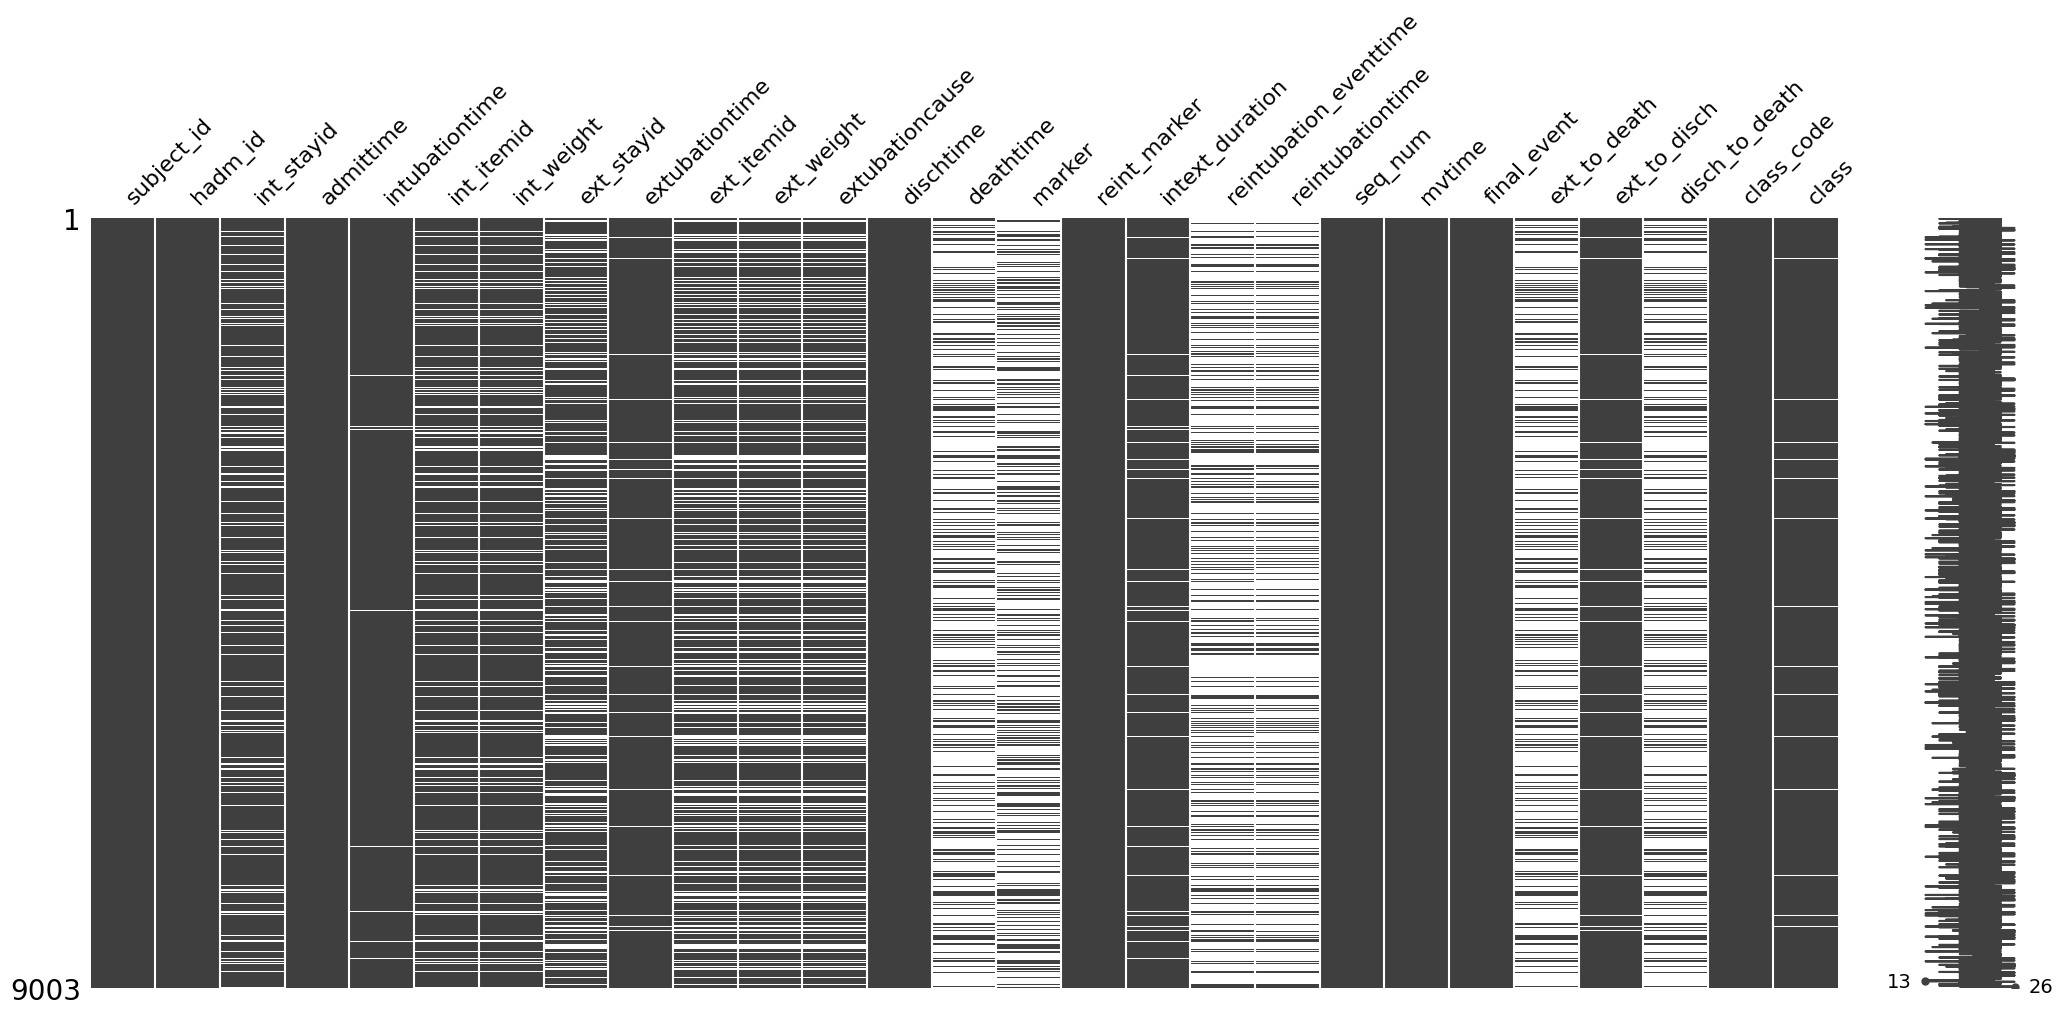

In [19]:
msno.matrix(subjectlist1_imputed_categorized)

In [42]:
(subjectlist1_imputed_categorized.intubationtime.isna() | subjectlist1_imputed_categorized.extubationtime.isna()).sum()

447

In [27]:
subjectlist1_imputed_categorized[subjectlist1_imputed_categorized['class'].isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
6,10007818,22987108,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,NaN,NaT,NaN,...,NaN,None,1,False,True,NaN,NaN,1250.0,9999,None
55,10090454,29525590,38669202.0,2169-02-05 17:14:00,2169-02-06 19:00:00,224385.0,54.0,NaN,NaT,NaN,...,2169-02-10 16:22:00,None,1,False,False,NaN,NaN,0.0,9999,None
102,10142197,20108756,36313195.0,2161-01-03 14:13:00,2161-01-04 00:18:00,224385.0,84.2,NaN,NaT,NaN,...,NaN,None,1,False,True,NaN,NaN,0.0,9999,None
118,10150335,24113307,33705553.0,2144-09-09 20:15:00,2144-09-17 01:00:00,224385.0,66.3,NaN,NaT,NaN,...,NaT,NaN,4,False,True,NaN,NaN,0.0,9999,None
226,10264447,27667745,32823287.0,2138-07-01 01:44:00,2138-07-01 22:00:00,224385.0,84.0,NaN,NaT,NaN,...,NaN,None,1,False,True,NaN,NaN,NaN,9999,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,19788246,20404156,35970013.0,2122-12-19 22:17:00,2122-12-23 01:55:00,224385.0,66.2,NaN,NaT,NaN,...,NaN,None,1,False,True,NaN,NaN,0.0,9999,None
8815,19789144,23993014,31699190.0,2152-10-26 02:45:00,2152-11-11 22:59:00,224385.0,51.5,NaN,NaT,NaN,...,2152-11-15 14:30:00,None,1,False,False,NaN,NaN,0.0,9999,None
8914,19893454,28167991,31167245.0,2163-04-14 00:00:00,2163-04-25 08:45:00,224385.0,108.0,NaN,NaT,NaN,...,NaT,NaN,3,False,True,NaN,NaN,NaN,9999,None
8922,19906067,26902247,35539951.0,2134-07-21 15:20:00,2134-07-22 09:18:00,224385.0,84.2,NaN,NaT,NaN,...,NaN,None,1,False,True,NaN,NaN,NaN,9999,None


In [285]:
(subjectlist1_imputed_categorized.class_code == 9999).sum()

584

In [34]:
# BEFORE
# Define your desired order
order = ['nonfailure', 'failure', 'death']

# Get value counts
value_counts = subjectlist1['class'].value_counts()

# Reorder by the specified item order
reordered_counts1 = value_counts.reindex(order)

print(reordered_counts1.sum())

6709


In [40]:
# subjectlist1[subjectlist1.mvtime == False]
# Define your desired order
order = ['nonfailure', 'failure', 'death']

# Get value counts
value_counts = subjectlist1[subjectlist1.mvtime == False]['class'].value_counts()

# Reorder by the specified item order
reordered_counts1 = value_counts.reindex(order)

print(reordered_counts1.sum())

4846


In [41]:
# AFTER subjectlist1_imputed_categorized
# Define your desired order
order = ['nonfailure', 'failure', 'death']
subjectlist1_imputed_categorized
# Get value counts

value_counts = subjectlist1_imputed_categorized[subjectlist1_imputed_categorized.mvtime == False]['class'].value_counts()

# Reorder by the specified item order
reordered_counts = value_counts.reindex(order)
print(reordered_counts.sum())

5920


In [ ]:
# Define your desired order
order = ['nonfailure', 'failure', 'death']

# Get value counts
value_counts = subjectlist1['class'].value_counts()

# Reorder by the specified item order
reordered_counts = value_counts.reindex(order)

print(reordered_counts)

In [25]:
subjectlist1_imputed_categorized.class_code.value_counts()

class_code
11       3614
221      1338
211      1195
212       948
1221      875
22221     279
9999      247
121       204
998        87
1222       80
2221       66
22222      39
999        31
Name: count, dtype: int64

In [46]:
subjectlist1_imputed_categorized.to_csv('../outputs/subjectlist1_imputed_categorized.csv')

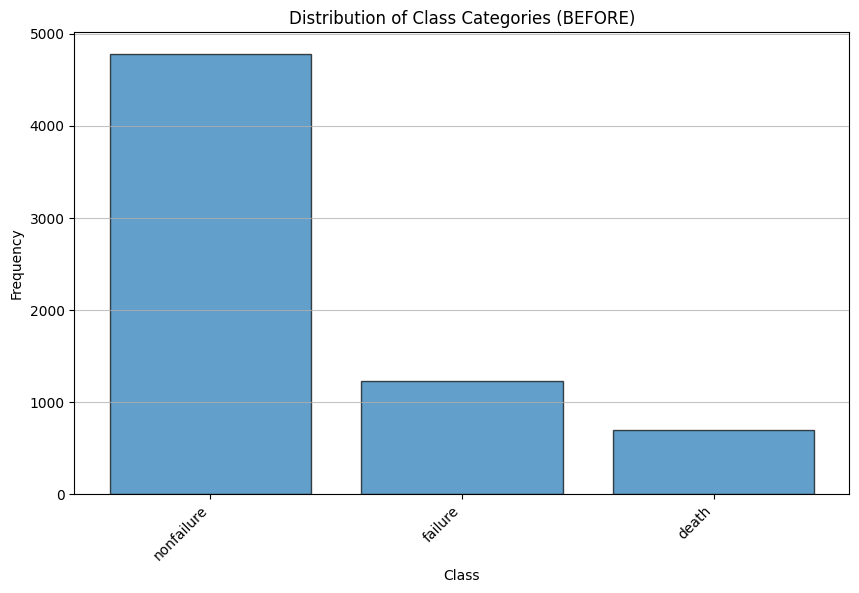

In [26]:
# Count the occurrences of each class
class_counts = subjectlist1['class'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (BEFORE)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

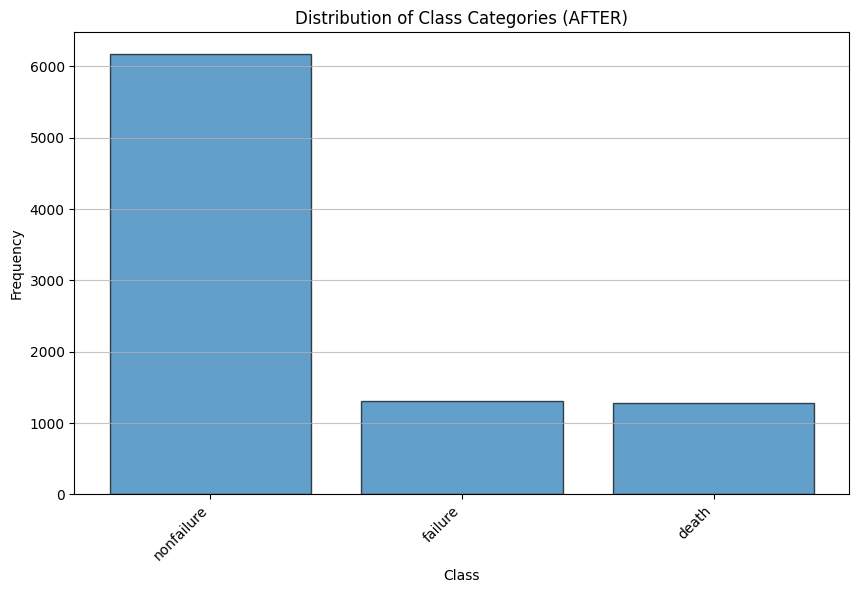

In [45]:
# Desired order for the categories
order = ['nonfailure', 'failure', 'death']

# Reordering the class_counts dictionary according to the specified order
# This ensures that when we plot, the bars follow this order.
reordered_counts = {key: class_counts[key] for key in order}

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(reordered_counts.keys(), reordered_counts.values(), edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (AFTER)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

In [268]:
subjectlist1_imputed[(subjectlist1_imputed.intubationtime.isna()) | (subjectlist1_imputed.intubationtime.isna())]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
21,10027602,28166872,NaN,2201-10-30 12:05:00,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,227194.0,...,2201-11-07 15:00:00,67.0,1,False,False,NaN,18772.0,NaN,211,failure
51,10085667,27382550,NaN,2192-12-11 19:38:00,NaT,NaN,NaN,36886741.0,2192-12-14 14:36:00,227194.0,...,2192-12-15 22:30:00,1914.0,1,False,False,NaN,7374.0,NaN,211,failure
86,10119017,20229125,NaN,2159-08-10 23:55:00,NaT,NaN,NaN,31009936.0,2159-08-11 17:12:00,227194.0,...,2159-08-14 06:38:00,3686.0,1,False,False,13228.0,13228.0,0.0,212,nonfailure
115,10150335,24113307,NaN,2144-09-09 20:15:00,NaT,NaN,NaN,33705553.0,2144-09-12 03:35:00,225468.0,...,2144-09-12 04:35:00,60.0,1,False,False,8095.0,8095.0,0.0,211,failure
135,10173670,21801929,NaN,2125-01-26 09:19:00,NaT,NaN,NaN,32131292.0,2125-02-02 13:06:00,227194.0,...,2125-02-02 13:30:00,24.0,1,False,False,NaN,20214.0,NaN,211,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,19607507,24462799,NaN,2148-12-30 20:49:00,NaT,NaN,NaN,31986541.0,2149-03-03 14:12:00,227194.0,...,NaT,NaN,2,False,False,NaN,92050.0,NaN,9999,NaN
8658,19623193,29413963,NaN,2146-02-12 20:35:00,NaT,NaN,NaN,38137204.0,2146-02-27 03:21:00,225468.0,...,NaT,NaN,3,False,True,8440.0,8440.0,0.0,221,nonfailure
8664,19632307,27941787,NaN,2145-01-24 17:37:00,NaT,NaN,NaN,36752828.0,2145-02-15 22:20:00,227194.0,...,NaT,NaN,2,False,True,-1339.0,-1339.0,0.0,22221,death
8777,19755487,25879196,NaN,2158-04-21 16:40:00,NaT,NaN,NaN,30562709.0,2158-04-23 15:25:00,227194.0,...,2158-05-02 00:45:00,12080.0,1,False,False,NaN,27316.0,NaN,212,nonfailure


In [172]:
len(single_row_results_list), len(multirow_candidates_list)

(0, 1038)

In [200]:
multirow_candidates_list[3]['candidates']

[{'index': 61,
  'current_pair': {'intubationtime': Timestamp('2118-05-09 19:02:00'),
   'extubationtime': NaT},
  'candidates': [('extubationtime', Timestamp('2118-05-10 19:00:00'))]}]

In [196]:
dd

9003

In [188]:
subjectlist1[subjectlist1.hadm_id == 23505435]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
6695,17349923,23505435,32002159,NaN,2161-07-11 16:54:00,NaT,NaN,NaN,32002159.0,2161-07-13 18:40:00,...,NaN,1,False,False,NaN,53190.0,NaN,9999,NaN,False
6696,17349923,23505435,32002159,NaN,2161-07-11 16:54:00,NaT,NaN,NaN,32002159.0,2161-07-24 12:19:00,...,19953.0,2,False,False,NaN,37731.0,NaN,212,nonfailure,False
6697,17349923,23505435,31989793,31989793.0,2161-07-11 16:54:00,2161-08-07 08:52:00,224385.0,129.4,NaN,2161-08-19 17:10:00,...,NaN,3,False,True,NaN,0.0,NaN,2221,nonfailure,False


In [259]:
# Initialize a counter for rows with more than one candidate
rows_with_multiple_candidates = 0

# A list to hold the specific entries (subject_id and hadm_id) with rows that have more than one candidate
entries_with_multiple_candidates = []

# Iterate through the multirow_candidates_list to find rows with more than one candidate
for entry in single_row_results_list:
    for candidate_info in entry['candidates']:
        # Check if there are more than one candidate for the current row
        if isinstance(candidate_info['candidates'], list) and len(candidate_info['candidates']) > 1:
            rows_with_multiple_candidates += 1
            # Add the entry to the list if not already included
            if entry not in entries_with_multiple_candidates:
                entries_with_multiple_candidates.append({'subject_id': entry['subject_id'], 'hadm_id': entry['hadm_id']})

# Now, rows_with_multiple_candidates holds the total count of rows with more than one candidate across all groups
# entries_with_multiple_candidates holds the entries (subject_id and hadm_id) that include such rows

print(f"Total rows with more than one candidate: {rows_with_multiple_candidates}")
print("Entries with rows that have more than one candidate:")
for entry in entries_with_multiple_candidates:
    print(entry)


Total rows with more than one candidate: 0
Entries with rows that have more than one candidate:


<Axes: >

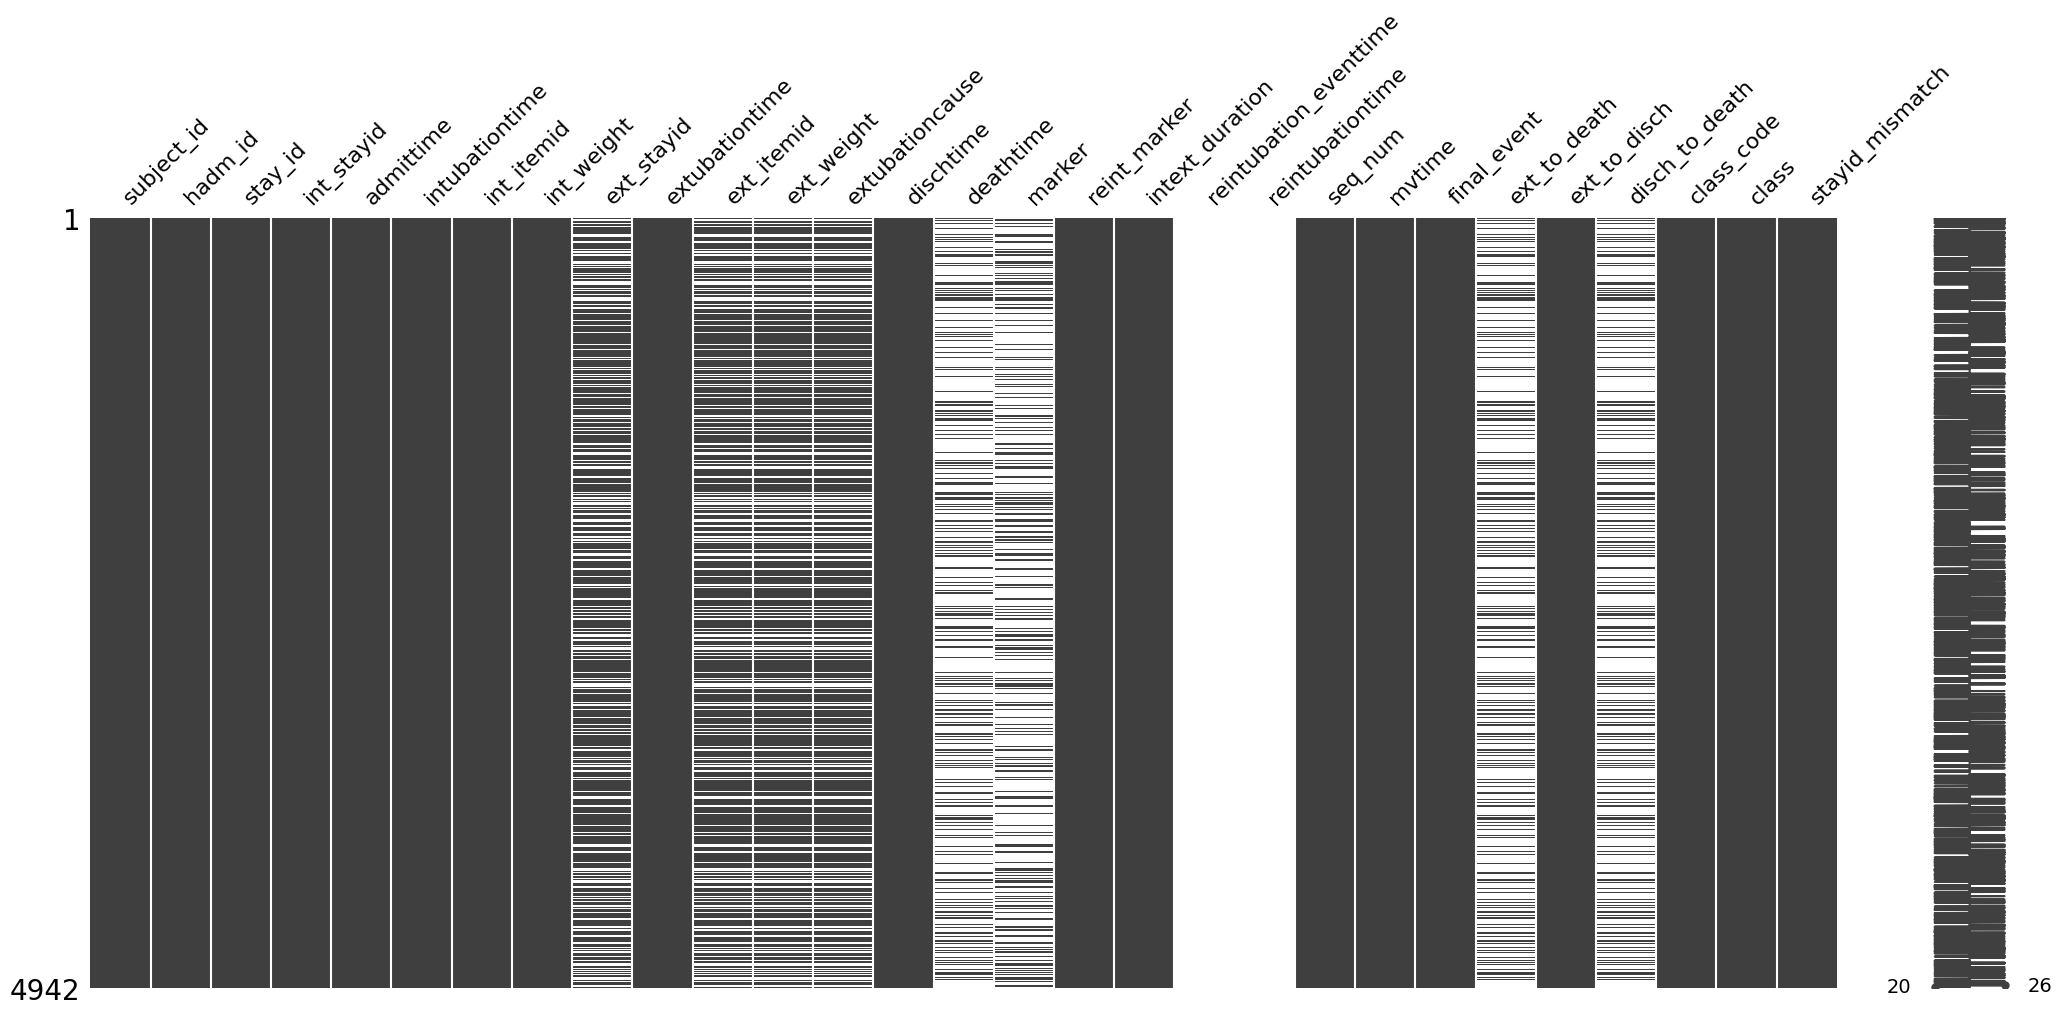

In [182]:
msno.matrix(subjectlist1[subjectlist1.reint_marker == False])